In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [11]:
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 330 kB 2.1 MB/s eta 0:00:01
  Using cached safetensors-0.5.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (461 kB)
     |█████████████                   | 324.2 MB 109.7 MB/s eta 0:00:05     |██████████▌                     | 260.4 MB 109.7 MB/s eta 0:00:05     |███████████                     | 275.1 MB 109.7 MB/s eta 0:00:05

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |█████████████████████▉          | 545.2 MB 151.2 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |█████████████████████████████▊  | 740.9 MB 159.7 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 797.1 MB 13 kB/s 
     |████████████████████████████████| 464 kB 36.1 MB/s eta 0:00:01
  Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
     |██████████████████████▎         | 286.5 MB 145.2 MB/s eta 0:00:01     |██████████████▊                 | 188.6 MB 125.3 MB/s eta 0:00:02     |████████████████▎               | 209.5 MB 125.3 MB/s eta 0:00:02     |███████████████████             | 244.4 MB 125.3 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 410.6 MB 7.3 kB/s 
     |████████████████████████████████| 121.6 MB 75 kB/s s eta 0:00:01    |████████████████████            | 75.8 MB 32.3 MB/s eta 0:00:02
     |████████████████████████████████| 176.2 MB 111 kB/s s eta 0:00:01
     |████████████████████████████████| 209.4 MB 50 kB/s /s eta 0:00:01
     |████████████████████████████████| 99 kB 3.4 MB/s  eta 0:00:01
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
     |████████████████████████████████| 14.1 MB 30.4 MB/s eta 0:00:01
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
     |████████████████████████████████| 823 kB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 56.5 MB 50.5 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 22 kB/s /s eta 0:00:01
     |████████████████████████████████| 196.0 MB 55 kB/s /s eta 0:00:01
     |████████████████████████████████| 23.7 MB 32.3 MB/s eta 0:00:01     |██████████

In [2]:
sys.path.append('../..')

In [3]:
from src.dataloader import cxrDataset, get_dataloader
import src.utils as utils

In [4]:
root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')

YEARS = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
image_dir = "extracted-images"
metadata = "metadata_with_supertables_filtered_notes_filtered.csv"
notes = "all_notes.csv"

In [5]:
metadatadf = pd.read_csv(root / metadata)
metadatadf.head()

/tmp/ipykernel_2309140/196610498.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  metadatadf = pd.read_csv(root / metadata)


,EMPI_NBR,ENCOUNTER_NBR,BED_LOCATION_START,BED_LOCATION_END,StudyDate,PatientID,StudyDescription,SeriesNumber,SeriesDescription,file,...,HOSPITAL_SERVICE,AccessionNumber,BodyPartExamined,Modality,WindowCenter,WindowWidth,RelativeXRayExposure,supertable_path,year,PatientID.1
0,da75ddb523faf9957500fdcd357ea98332caf28a431593...,35fe45549543fa7eed07ade8676ad3fd9d8f2f67f15fe5...,2015-01-09 12:41:57,2015-01-12 20:53:23,2015-01-10,da75ddb523faf9957500fdcd357ea98332caf28a431593...,XR CHEST 1 VIEW PORTABLE,1,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,CARDIOVASCULAR SUR,ceaac7e68859114498994b393a2cdb135cf17d49fec8eb...,PORT CHEST,CR,NaN,NaN,1912.0,/labs/kamaleswaranlab/niffler-data/chest_xrays...,2015,NaN
1,8c792db8aac2b71b9a77bca37cab72ec9214ced6ecab3f...,95a26a594faf995b51a0b1abce61025184dd8acbdc47f6...,2015-05-02 15:12:35,2015-05-06 14:46:11,2015-05-03,8c792db8aac2b71b9a77bca37cab72ec9214ced6ecab3f...,XR CHEST 1 VIEW PORTABLE,1001,NaN,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,CARDIOVASCULAR SUR,d626d908b6aece6616bd02ae252a6d527bbb474b23d55b...,CHEST,CR,NaN,NaN,NaN,/labs/kamaleswaranlab/niffler-data/chest_xrays...,2015,NaN
2,46150524cfb83a79e310d39bf20c5d1c21ddb842123a6f...,59d0517815e05cdaf826db080348daf9b8f11f793deacc...,2015-05-02 23:29:05,2015-05-05 18:33:48,2015-05-03,46150524cfb83a79e310d39bf20c5d1c21ddb842123a6f...,XR CHEST 1 VIEW PORTABLE,3,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,HOSPITAL MEDICINE,b3c5db31414eed4a137f9e6552a196558b5aa3be890d8e...,PORT CHEST,CR,2048.0,4096.0,1639.0,/labs/kamaleswaranlab/niffler-data/chest_xrays...,2015,NaN
3,696c20a9296be1a05990f595cef64f8d4cb0fd6ab0d344...,88981cfc03fbc9eb96fdb384ae85d14195569d6cad7603...,2015-04-28 16:12:49,2015-05-01 18:58:00,2015-04-29,696c20a9296be1a05990f595cef64f8d4cb0fd6ab0d344...,XR CHEST 1 VIEW PORTABLE,1001,NaN,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,THORACIC SURGERY,c843721b42cd8eda7ae5261b02e5a566ac3d4d4e0dbedd...,CHEST,DX,512.0,1024.0,NaN,/labs/kamaleswaranlab/niffler-data/chest_xrays...,2015,NaN
4,ec1ecd944ea8abe1cdd62476a5516a25eae2685e603c02...,e967ee40a9c4757d6655fc9372a72967df4ab40456bb4e...,2015-04-10 11:54:45,2015-04-22 15:17:00,2015-04-12,ec1ecd944ea8abe1cdd62476a5516a25eae2685e603c02...,XR CHEST 1 VIEW PORTABLE,2,AP,/labs/kamaleswaranlab/niffler-data/chest_xrays...,...,CARDIOVASCULAR SURG,f35158b3486f119773fba2ea14f116081050baaeb796fb...,PORT CHEST,DX,2048.0,4096.0,1341.0,/labs/kamaleswaranlab/niffler-data/chest_xrays...,2015,NaN


In [6]:
notesdf = pd.read_csv(root / notes)
notesdf.head()

/tmp/ipykernel_2309140/106063143.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  notesdf = pd.read_csv(root / notes)


,Unnamed: 0,ACC_NBR,PATIENT_ID,EMPI_NBR,ENCNTR_ID,HNAM_DOCUMENT_CLINICAL_ID,HNAM_DOCUMENT_CLINICAL_NM,DAY_VERIFIED,DOC_TEXT,DOC_ABSTRACT,EVENT_DOCUMENT_DESC,EVENT_DOCUMENT_KEY
0,0,5a207ebfcf8fee0a03f2b44fd3714b56600f96f6c055d0...,4638bdabac895e42cf5e556ad317fb1cbe239804df3e2e...,da75ddb523faf9957500fdcd357ea98332caf28a431593...,1f5110b71820b44721657ceb6895f592464fe533f23098...,ea73b73f34959a5ad5169df1e4b8b125acd951f093ea6f...,XR Chest Decubitus Bilateral,01/15/2015,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,d4d31127e487d90af10380a1af2734b9fad42cd9156867...,76761074.0
1,1,1d8ccb168162a0678cdbc5335cbd4b3e1ae0b5b348f5ef...,f111eceedc616aae8737743a4cfa74501429fe1e54d67c...,ec1ecd944ea8abe1cdd62476a5516a25eae2685e603c02...,450d268f533afb532cb6b40ea19b9fbe4aabaed82aaa38...,ea73b73f34959a5ad5169df1e4b8b125acd951f093ea6f...,XR Chest Decubitus Bilateral,05/04/2015,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,cfcad629e9cdedf248e3e4b0233ed87cd17826e2916f03...,79690536.0
2,2,a877c0f8d0f787b7a2f732ecf5344b16f5768cf65b8eb1...,bdbafcce2001f4f7b2de71b3e1d43f811fc666e3972fca...,467d53a521c6f18a3ffa901e79f2065ff3c4e4783e1eaf...,18b578f5bcbb821c658a337c7f71047833088b2629a2fa...,ea73b73f34959a5ad5169df1e4b8b125acd951f093ea6f...,XR Chest Decubitus Bilateral,02/17/2015,REPORT\r\rBilateral decubitus views of the che...,REPORT\r\rBilateral decubitus views of the che...,d9212f4ecb01f5ab51b26381c30b2cdd2a1bd4b4496890...,77616818.0
3,3,a79e76957d0f46c581178878ddf2ca61a8070486ae9c72...,e332c3844d9a284ee513c9aea15d68a6b29cec05c8499f...,d3f7dc78321c5a2b51b24ca1e26d924c23f2dbd14f8975...,4f5ae14512210d5c3d640820172186fb29479f12fa9490...,ea73b73f34959a5ad5169df1e4b8b125acd951f093ea6f...,XR Chest Decubitus Bilateral,04/23/2018,REPORT\r\rBilateral decubitus chest\n\nCOMPARI...,REPORT\r\rBilateral decubitus chest\n\nCOMPARI...,dbd11ce5a491955aaa84e383369aa312f2c16ab28edb05...,107521288.0
4,4,56bb29d96ebe39b9fcb87e70701bcc0d4aaf3fc895e68c...,4d010eb4492af54a27e174a81fc551f8ee8dbf266382c7...,3236f9d52575b4bb1267bccc5870247f974c1f63de9402...,f80aa1318a57c301da0fbdbf57c7035b257b228c29e789...,ea73b73f34959a5ad5169df1e4b8b125acd951f093ea6f...,XR Chest Decubitus Bilateral,08/14/2015,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,REPORT\r\rXR Chest Decubitus Bilateral\n\nCLIN...,6fc6d6c7ef79722272a84d5aaf91778d3ef6fbb66d6ad7...,82359325.0


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
dataloader = get_dataloader(
    df=metadatadf.iloc[:2000],
    notesdf=notesdf,
    root_dir=str(root),
    image_dir=str(image_dir),
    transform=transform,
    acc_to_path=utils.acc_to_path,
    batch_size=1,
    max_sequence_length=20
)

/hpc/home/ma618/cxrgen/scratch/notebooks/../../src/dataloader.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StudyDate'] = pd.to_datetime(df['StudyDate'])


In [9]:
for batch_images, batch_mask, batch_notes in dataloader:
    # batch_images shape: [batch_size, seq_length, channels, height, width]
    # batch_metadata contains sequence information and valid_mask
    break

In [32]:
def preprocess_report(report_text: str) -> str:
    # Remove special characters and extra whitespace
    report = report_text.replace('\r', ' ').replace('\n', ' ')
    report = ' '.join(report.split())
    return report

def extract_findings(report_text: str) -> str:
    # Convert to lowercase for case-insensitive matching
    report_lower = report_text.lower()
    
    # Look for either "findings" or "impression" (with or without a slash)
    start_markers = ["findings:", "impression:", "findings/impression:", "impression/findings:"]
    print(report_lower)
    
    if "findings/impression:" in report_lower:
        print("yes")
    # Find the start of the findings section
    start_idx = -1
    for marker in start_markers:
        if marker in report_lower:
            start_idx = report_lower.find(marker)
            print(start_idx)
            break
    
    if start_idx == -1:
        return ""  # No findings/impressions section found
    
    # Get the text after the marker
    findings_text = report_lower[start_idx:]
    
    # Find the next section if it exists (marked by a newline and uppercase word)
    sections = findings_text.split('\n')
    cleaned_sections = []
    print(findings_text)
    for section in sections:
        # If we find a new all-caps section header, stop
        if section.strip().isupper() and len(section.strip()) > 0:
            break
        cleaned_sections.append(section)
    print(sections)
    # Join the relevant sections and clean up
    findings = ' '.join(cleaned_sections)
    
    # Remove the "FINDINGS:" or "IMPRESSION:" header
    for marker in start_markers:
        findings = findings.lower().replace(marker, "", 1)
    
    # Clean up extra whitespace and special characters
    findings = findings.replace('\r', ' ').replace('\n', ' ')
    findings = ' '.join(findings.split())
    
    return findings.strip()

In [33]:
batch_notes[0][0]

'REPORT\r\rXR Chest 1 View Portable \n\nCLINICAL INDICATION: .;Cough\n\nCOMPARISON: 7/3/2014\n\nFINDINGS/IMPRESSION: \nEvaluation compromised by respiratory motion artifact. No focal pulmonary\nconsolidation or pneumothorax. Consider PA and lateral radiographs to further\nassess as indicated. \n'

In [34]:
extract_findings(batch_notes[0][0])

xr chest 1 view portable 

clinical indication: .;cough

comparison: 7/3/2014

findings/impression: 
evaluation compromised by respiratory motion artifact. no focal pulmonary
consolidation or pneumothorax. consider pa and lateral radiographs to further
assess as indicated. 

yes
96
impression: 
evaluation compromised by respiratory motion artifact. no focal pulmonary
consolidation or pneumothorax. consider pa and lateral radiographs to further
assess as indicated. 

['impression: ', 'evaluation compromised by respiratory motion artifact. no focal pulmonary', 'consolidation or pneumothorax. consider pa and lateral radiographs to further', 'assess as indicated. ', '']


'evaluation compromised by respiratory motion artifact. no focal pulmonary consolidation or pneumothorax. consider pa and lateral radiographs to further assess as indicated.'

In [35]:
from diffusers import StableDiffusionPipeline
import torch

In [36]:
torch.cuda.empty_cache()

### model_path = "/hpc/group/kamaleswaranlab/cxrgen/roentgen/roentgen"
device='cuda'  # or mps, cpu...

pipe = StableDiffusionPipeline.from_pretrained(model_path).to(torch.float32).to(device)

prompt = "mild to moderate interstitial edema pattern" #batch_notes[0][0] #"big left-sided pleural effusion"

output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)

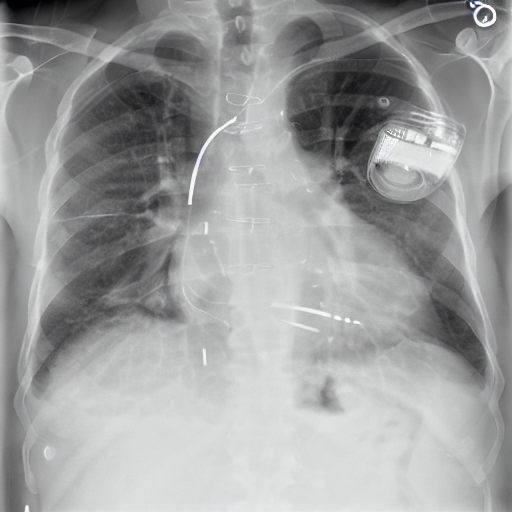

In [25]:
output.images[0]

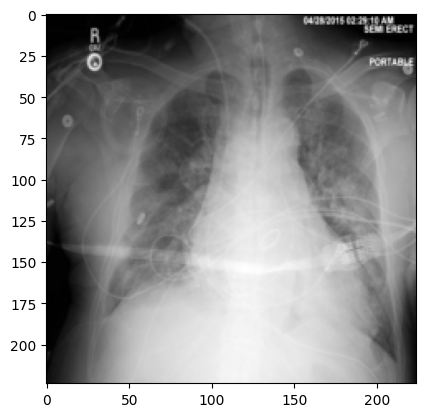

In [26]:
plt.imshow(batch_images[0,0,0,:,:], cmap = 'grey')
plt.show()